# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *"A non-local algorithm for image denoising"* (autorzy: Antoni Buades, Bartomeu Coll i Jean Michel Morel) na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{2}
\end{equation}

gdzie:
\begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{3}
\end{equation}

- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując: jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [ ]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

mat = loadmat('MR_data.mat')

mat1 = mat['I_noisy1']
mat2 = mat['I_noisy2']
mat3 = mat['I_noisy3']
mat4 = mat['I_noisy4']
mat5 = mat['I_noisefree']





--2022-04-26 07:05:02--  https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1332591 (1.3M) [application/octet-stream]
Saving to: ‘MR_data.mat’

MR_data.mat         100%[===================>]   1.27M  --.-KB/s    in 0.06s   

2022-04-26 07:05:03 (19.7 MB/s) - ‘MR_data.mat’ saved [1332591/1332591]



In [61]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g

def fgaussian_maska(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g/g.sum()


def Z(alfa, sigma, area_V, contex_size_half, image, ok, ii, jj):
  
  X,Y = ok.shape
  Z=0
  suma = 0
  v = fgaussian_maska(contex_size_half * 2 ,sigma)

  for i in range(contex_size_half, X -  contex_size_half):
    for j in range(contex_size_half, Y - contex_size_half):
            

      VNx = v * image[ii-contex_size_half:ii+contex_size_half + 1, jj - contex_size_half: jj + contex_size_half + 1]
      VNp = v * ok[i-contex_size_half:i+contex_size_half + 1, j - contex_size_half: j + contex_size_half + 1] 

      Xii = np.sqrt(((VNp - VNx)**2).sum())
      ex = np.exp((-(Xii**2))/(alfa*sigma*sigma))
      Z += ex
      suma += ex*ok[i,j]


  return  suma/Z

def NLM(alfa, sigma, area_V, contex_size_half, image):
  Inew = image.copy()
  X,Y= Inew.shape

  for i in range(contex_size_half + int(area_V//2), X -  contex_size_half - int(area_V//2)):
      for j in range(contex_size_half + int(area_V//2), Y - contex_size_half - int(area_V//2)):
        ok = image[i - contex_size_half - int(area_V//2): i + contex_size_half + int(area_V//2) + 1, j - contex_size_half + int(area_V//2): j + contex_size_half + int(area_V//2)+ 1]
        new = Z(alfa, sigma, area_V, contex_size_half, image, ok, i, j )
        Inew[i,j] = new

  return Inew



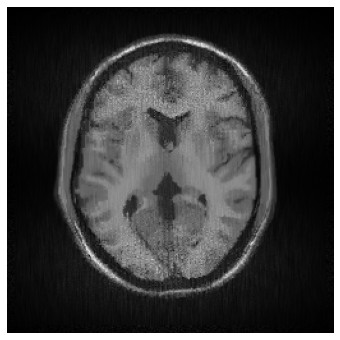

In [71]:
alfa = 30
sigma = 1
area_V = 8
contex_size_half = 2
image = mat2

new_I = NLM(alfa, sigma, area_V, contex_size_half, image)

plt.figure(figsize=(6,6))
plt.imshow(new_I)
plt.gray()
plt.axis('off')
plt.show()



In [76]:

def new_pix (okno, okno_s, var):
  suma = 0
  X,Y = okno.shape
  g = fgaussian(okno_s,var)
  sum_g = 0
  Wn = 0

  for i in range(X):
    for j in range(Y):

      y=np.sqrt(((X//2-X)**2) + ((Y//2-Y)**2))
      gaus= np.exp(-(y**2)/(2*(var**2)))
      suma=suma+gaus*okno[i,j]
      Wn += g[i,j]

    suma=suma/Wn
    return suma


def gaus (mat1, okno_s, var):

  IConv = mat1.copy()
  X,Y = IConv.shape
  new_Conv = np.zeros((IConv.shape))

  for i in range(int(okno_s//2), X - int(okno_s//2)):
    for j in range(int(okno_s//2), Y - int(okno_s//2)):

      okno = IConv[i-int(okno_s//2):i+int(okno_s//2)+1,j-int(okno_s//2):j+int(okno_s//2)+1]  
      new_Conv[i][j] = new_pix(okno, okno_s, var)

  return new_Conv


def new_pix2(okno,var,r):
    X,Y = okno.shape
    suma=0
    Wn = 0

    for i in range(X):
        for j in range(Y):
            
            y=np.sqrt(((X//2-i)**2)+((Y//2-j)**2))
            gaus= np.exp(-(y**2)/(2*(var**2)))
            
            diff=np.abs(okno[X//2,Y//2] - okno[i,j])
            gaus_diff= np.exp( -(diff**2)/(2*(r**2)) )
            
            suma = suma + gaus*gaus_diff * okno[i,j]
            Wn += gaus*gaus_diff

    return suma/Wn


def bil(okno_s, var, r, mat1):
  
  IBilateral =  mat1.copy()
  X,Y = IBilateral.shape

  for i in range(int(okno_s//2), X - int(okno_s//2)):
    for j in range(int(okno_s//2), Y - int(okno_s//2)):

      okno =  mat1[i-int(okno_s//2):i+int(okno_s//2)+1,j-int(okno_s//2):j+int(okno_s//2)+1]  
      IBilateral[i][j] = new_pix2(okno, var, r)
  return IBilateral

In [78]:
!pip install memory_profiler
%load_ext memory_profiler 

print("filtr Gaussa")

print('Timing (5 runs): ')
saved_timing1 = %timeit -r 5 -n 1 -o gaus(image, 5, 0.8)
print('Memory usage: ')
%memit gaus(image, 5, sigma)
print('\n')

print("\nfiltr bilateralny")

print('Timing  5 runs): ')
saved_timing1 = %timeit -r 5 -n 1 -o bil(5, sigma, 20, image)
print('Memory usage: ')
%memit bil(5, sigma, 20, image)
print('\n')

print("\nfiltr NLM")


print('Timing (5 runs): ')
saved_timing1 = %timeit -r 5 -n 1 -o NLM(alfa, sigma, area_V, contex_size_half, image)
print('Memory usage: ')
%memit NLM(alfa, sigma, area_V, contex_size_half, image)
print('\n')

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
filtr Gaussa
Timing (5 runs): 
1 loop, best of 5: 3.97 s per loop
Memory usage: 
peak memory: 207.21 MiB, increment: 0.00 MiB



filtr bilateralny
Timing  5 runs): 
1 loop, best of 5: 13.9 s per loop
Memory usage: 
peak memory: 207.21 MiB, increment: 0.00 MiB



filtr NLM
Timing (5 runs): 
1 loop, best of 5: 10.1 s per loop
Memory usage: 
peak memory: 207.21 MiB, increment: 0.00 MiB




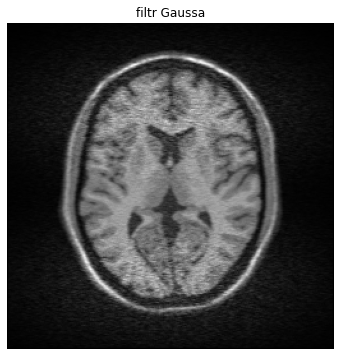

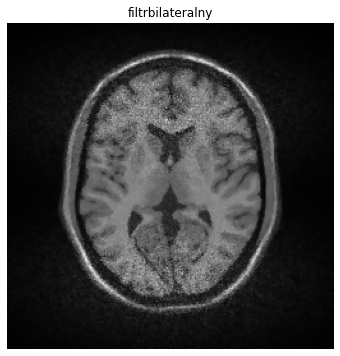

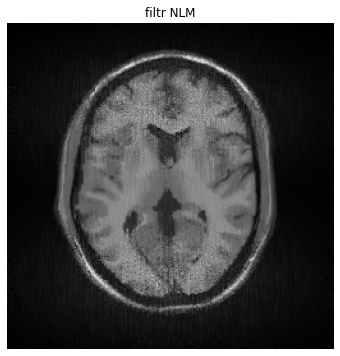

In [77]:
new_I = gaus(image, 3,  0.8)

plt.figure(figsize=(6,6))
plt.imshow(new_I)
plt.gray()
plt.axis('off')
plt.title('filtr Gaussa')
plt.show()

new_I = bil(5, sigma, 20, image)

plt.figure(figsize=(6,6))
plt.imshow(new_I)
plt.gray()
plt.axis('off')
plt.title('filtrbilateralny')
plt.show()


new_I = NLM(alfa, sigma, area_V, contex_size_half, image)

plt.figure(figsize=(6,6))
plt.imshow(new_I)
plt.gray()
plt.axis('off')
plt.title('filtr NLM')
plt.show()



Filtr Gausa działa najmniej dokładnie - pozbywa się szumów kosztem sąsiednich pikseli przez co obraz jest bardzo rozmazany. Jest za to zdecydowanie najszybszym ze sposobów.
Co ciekawe filtr bilateralny dla podanych współczynników potrzebuje więcej czasu niż filtr NLM (o 3 s więcej) - mimo że według mnie dla danego przypadku filtr NLM działa też lepiej - oby dwa filtry zachowują ostrość obrazu, jednak NLM lepiej (moim zdaniem) pozbywa się szumów (kosztem widocznego jakby pionowego kreskowania, nie wiem jak to nazwać) 